# Transfer Function Modeling (with initial guess)

Text(0.5, 0, 'Frequency (Hz)')

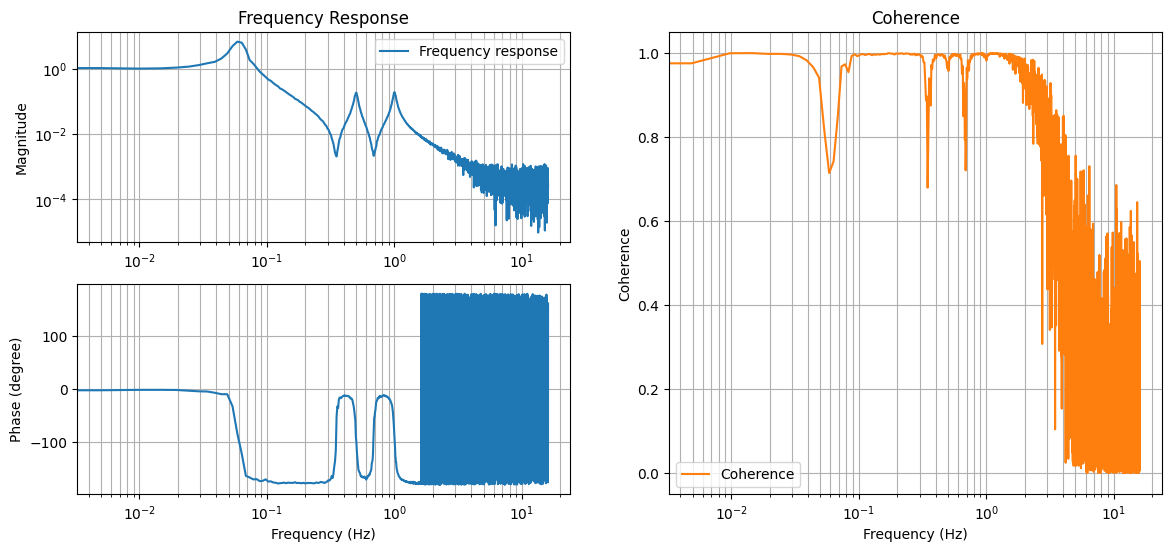

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol

# Define the transfer function (We don't know this yet!)
# This is the transfer function we defined for x1 in sensor matrix diagonalization tutorial.
s = control.tf("s")
fs = 32
t = np.linspace(0, 1024, 1024*fs)

w1 = 0.06*2*np.pi
w4 = 0.5*2*np.pi
w5 = 1*2*np.pi
q1 = 10
q4 = 20
q5 = 20
tf1 = w1**2 / (s**2+w1/q1*s+w1**2)
tf4 = 0.01*w4**2 / (s**2+w4/q4*s+w4**2)
tf5 = 0.01*w5**2 / (s**2+w5/q5*s+w5**2)

tf = tf1 + tf4 + tf5

# For the sake of reproducibility
np.random.seed(123)

# Unit white noise injection
u = np.random.normal(loc=0, scale=1/np.sqrt(fs), size=len(t))

# Measure the output
_, y, = control.forced_response(tf, U=u, T=t)

# Let's add some measurement noise
y += np.random.normal(loc=0, scale=1e-3/np.sqrt(fs), size=len(t))

# Obtain the frequency response
f, p_uy = scipy.signal.csd(u, y, fs=fs, nperseg=int(len(t)/5))
_, p_uu = scipy.signal.welch(u, fs=fs, nperseg=int(len(t)/5))
_, p_yy = scipy.signal.welch(y, fs=fs, nperseg=int(len(t)/5))

frequency_response = p_uy/p_uu
coherence = abs(p_uy)**2/p_uu/p_yy

plt.figure(figsize=(14, 6))
plt.subplot(221)
plt.title("Frequency Response")
plt.loglog(f, abs(frequency_response), label="Frequency response")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
# plt.xlabel("Frequency (Hz)")

plt.subplot(223)
plt.semilogx(f, 180/np.pi*np.angle(frequency_response))
# plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (Hz)")

plt.subplot(122)
plt.title("Coherence")
plt.semilogx(f, coherence, color="C1", label="Coherence")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Coherence")
plt.xlabel("Frequency (Hz)")
# ^Here's what we measured

In [2]:
# Data at frequency above ~2 Hz is plagued with noise, let's filter them out.
# Data at ~0.32 and ~0.65 Hz have low coherence. But that doesn't mean we should
# filter them out.
# The low coherence was due to the presences of the complex zeros in the transfer function,
# which is a characteristic of the system we're trying to moddel.
# And we wanna get rid of the 0 frequency data point.
frequency_response_fit = frequency_response[(f>0)*(f<2)]
f_fit = f[(f>0)*(f<2)]

Text(0.5, 0, 'Frequency (Hz)')

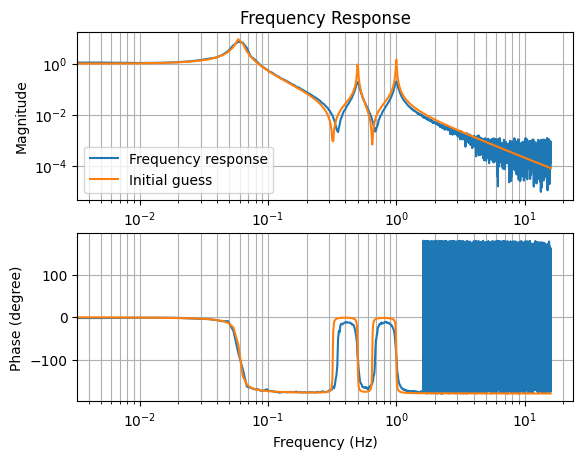

In [3]:
# Seed the random seed
np.random.seed(2)  # For education purposes, try other values yourself.

# To use a curvefit instance, we need to define several attributes,
# xdata, ydata, model, cost, and optimizer (and optionally optimizer_kwargs, ...).
# The kontrol.curvefit.TransferFunctionFit class has predefined cost and optimizer.
# In addition, we have to specify an intial guess x0.
curvefit = kontrol.curvefit.TransferFunctionFit()
curvefit.xdata = f_fit
curvefit.ydata = frequency_response_fit

# To use a ComplexZPK instance, we need to specify the number of complex zeros pairs and
# number of complex pole pairs.
# From the frequency response data, we see 2 notches and 3 peaks, which correspond to 
# 2 complex zero pairs and 3 complex pole pairs.
# The roll-off at high frequency is 2 orders of magnitude per decade, which means
# there're 2 more poles than zeros. The analysis above agrees with this observation.
# Here, log_args=True means that we're scaling the parameters logrithmically, 
# which is useful because we know the poles and zeros span across different magnitude in frequency.
curvefit.model = kontrol.curvefit.model.ComplexZPK(nzero_pairs=2, npole_pairs=3, log_args=True)

# Inital guess, peaks are at 0.06 (Q~10), 0.5 (Q~100), and 1 (Q~100) Hz.
# Notches at 0.32 Hz (Q~100), 0.65 Hz (Q~100)
# Gain at 1.

# The model parameters is arranged in a list as [f1, q1, f2, q2, ... k],
# where f1, and q1 is the frequency and Q factor of the zeros/poles, and k is the static gain.
x0 = [0.32, 100, 0.65, 100, 0.06, 10, 0.5, 100, 1, 100, 1]
x0 = np.log10(x0)  # Remember we're fitting the logarithm of the parameters.

# Compare inital guess with the measurement.
# plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.title("Frequency Response")
plt.loglog(f, abs(frequency_response), label="Frequency response")
plt.loglog(f, abs(curvefit.model(f, args=x0)), label="Initial guess")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
# plt.xlabel("Frequency (Hz)")

plt.subplot(212)
plt.semilogx(f, 180/np.pi*np.angle(frequency_response))
plt.semilogx(f, 180/np.pi*np.angle(curvefit.model(f, args=x0)))
# plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (Hz)")

In [4]:
# ^Inital guess good enough, let's proceed.
curvefit.x0 = x0
curvefit.options = {"maxiter":len(x0)*1000}  # options given to the scipy.optimize.minimize function.
# We increase the maximum number of iteration because it wasn't enough.
results = curvefit.fit()

Text(0.5, 0, 'Frequency (Hz)')

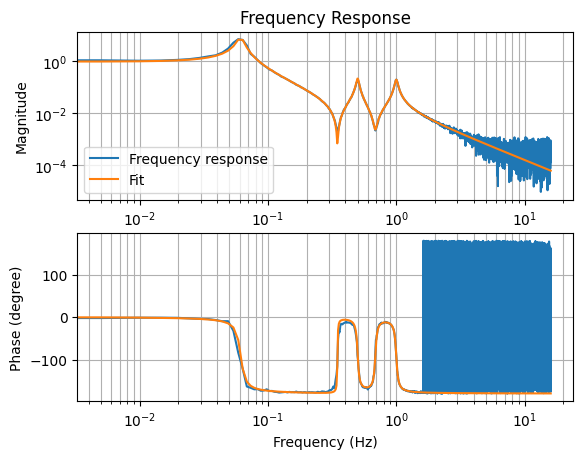

In [5]:
# plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.title("Frequency Response")
plt.loglog(f, abs(frequency_response), label="Frequency response")
plt.loglog(f, abs(curvefit.model(f, args=results.x)), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
# plt.xlabel("Frequency (Hz)")

plt.subplot(212)
plt.semilogx(f, 180/np.pi*np.angle(frequency_response))
plt.semilogx(f, 180/np.pi*np.angle(curvefit.model(f, args=results.x)))
# plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (Hz)")

In [6]:
# Let's inspect the fitted transfer function
print("True transfer function:\n", tf)
print("Fitted transfer function:\n", curvefit.model.tf.minreal())

True transfer function:
 
       0.6356 s^4 + 0.1786 s^3 + 14.89 s^2 + 1.629 s + 56.48
--------------------------------------------------------------------
s^6 + 0.5089 s^5 + 49.56 s^4 + 11.23 s^3 + 397 s^2 + 16.01 s + 55.38

Fitted transfer function:
 
        0.6354 s^4 + 0.1516 s^3 + 14.86 s^2 + 0.9622 s + 56.46
----------------------------------------------------------------------
s^6 + 0.5065 s^5 + 49.55 s^4 + 11.09 s^3 + 396.9 s^2 + 19.01 s + 57.55



In [7]:
# ^Close enough!
# Let's export the transfer function for future purposes.
curvefit.model.tf.save("transfer_function_x1_with_guess.pkl")

In [8]:
# Alternatively, export the Foton string and install it to the digital system
curvefit.model.tf.foton(root_location="n")

'zpk([0.002157+i*0.347726;0.002157+i*-0.347726;0.016831+i*0.686452;0.016831+i*-0.686452],[0.003622+i*0.061092;0.003622+i*-0.061092;0.011376+i*0.499619;0.011376+i*-0.499619;0.025306+i*0.999682;0.025306+i*-0.999682],0.981029,"n")'